# Common part for training and executing the model

## Install and Import required libraries

In [ ]:
#!pip install nsepy

In [5]:
#Importing the libraries
#from nsepy import get_history
#import datetime as dt

import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt

In [1]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
#sc = StandardScaler()

## Set common variables

In [2]:
n_Tail_Records = 90
training_Split_per = 0.8
time_steps = 60
pred_days = 15

## Get the stock price dataset

In [3]:
#start = dt.datetime(2018,1,1)
#end = dt.datetime(2021,11,30)
#train_dataset = get_history(symbol='SBIN',start=start,end=end)

#start = dt.datetime(2021,12,1)
#end = dt.datetime(2022,2,14)
#test_dataset = get_history(symbol='SBIN',start=start,end=end)

# train_dataset = pd.read_csv('stk_data_train.csv')
# test_dataset = pd.read_csv('stk_data_test.csv')

In [6]:
# https://finance.yahoo.com/quote/%5ENSEI/history

PriceDataSet = pd.read_csv('NSEI_Historical_yf.csv')

### Explore data and do required clean up

In [10]:
# PriceDataSet.head()
# len(PriceDataSet)
# PriceDataSet.describe()
PriceDataSet.isnull().any()
# PriceDataSet.info()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [8]:
def getCleanedData(PriceDataSet):
  cleanedPriceDataSet = PriceDataSet[PriceDataSet['Close'].isnull() == False]
  return cleanedPriceDataSet

In [9]:
PriceDataSet = getCleanedData(PriceDataSet)

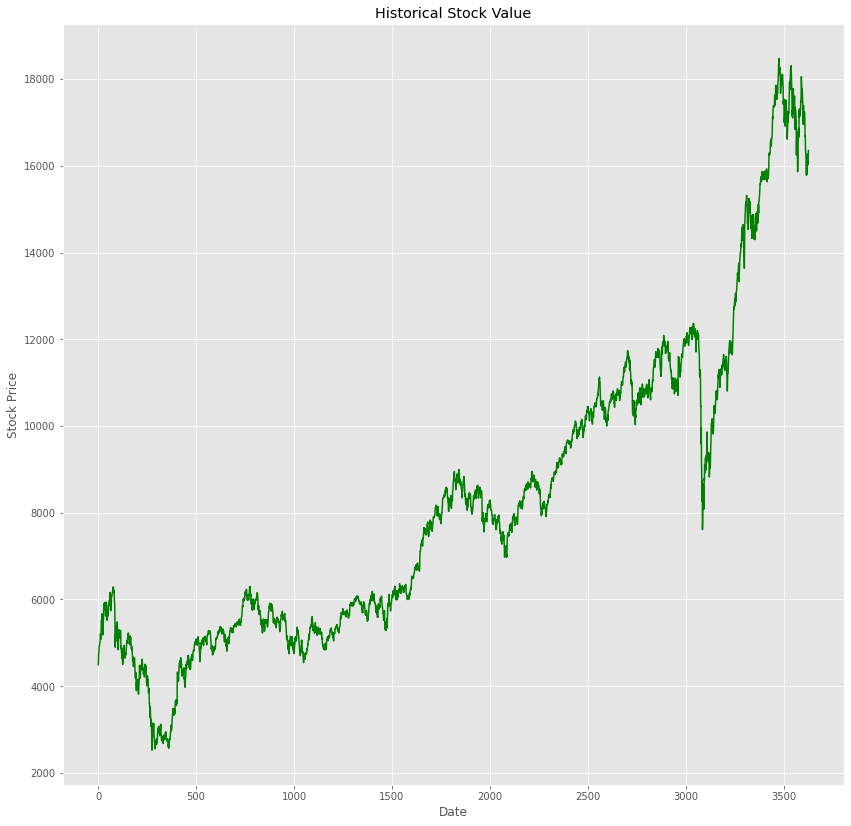

In [13]:
#Visualizing the fetched data
plt.figure(figsize=(14,14))
plt.style.use('ggplot')
plt.plot(PriceDataSet['Close'], color = 'green')
#plt.plot(PriceDataSet['Date'], PriceDataSet['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# Build and Train the LSTM Model

## Data Preprocessing

### Split the data into training and testing sets

In [14]:
trainingSize = round(len(PriceDataSet) * training_Split_per) # Selecting 80 % for training and 20 % for testing
trainDataSet = PriceDataSet[:trainingSize]
testDataSet = PriceDataSet[trainingSize:]

#Getting only Open/Close Price
#trainPrices = trainDataSet.iloc[:, 1:2].values
#testPrices = testDataSet.iloc[:, 1:2].values

#loc is returing a series, so converting into 2D array and transposing into column values
trainPrices = np.array([trainDataSet.loc[:,'Close']]).transpose()
testPrices = np.array([testDataSet.loc[:,'Close']]).transpose()

### Feature Scaling

In [15]:
X_train = sc.fit_transform(trainPrices)
X_test = sc.transform(testPrices)

## Split the data in to batches

### Helper methods

In [16]:
# def batch_data(X, sequence_length, batch_size):
#   # processing data in batches in parallel, this results in loosing some data which doesn't fit into total batches

#   # batch_size = # of rows at a time
#   # sequence_length = # of values taken in one batch

#   n_batches = len(X) // batch_size
#   X = X[:n_batches*batch_size]

#   features, targets = [], []
  
#   for i in range(0, (len(X) - sequence_length)):
#     features.append(X[i : i+sequence_length])
#     targets.append(X[i + sequence_length])  
  
#   return features, targets

In [17]:
def batch_time_data(X, time_steps):
  
  ts_len = len(X)
  features, targets = [], []
  
  for i in range(time_steps,ts_len):
    features.append(X[i-time_steps:i,0])
    targets.append(X[i,0])

  return features, targets

In [18]:
# Just to check the batch values

#X_train, y_train = batch_time_data(trainPrices, 5)
#X_test, y_test = batch_time_data(testPrices, 5)

#print(X_test)
#print(y_test)

In [19]:
X_train, y_train = batch_time_data(X_train, time_steps)
X_test, y_test = batch_time_data(X_test, time_steps)

In [20]:
# Reshape the data in 3D

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Defining the LSTM Recurrent Model

In [21]:
# Model Architecture

unitNos = 64
regressor = tf.keras.models.Sequential()
regressor.add(tf.keras.layers.LSTM(units=unitNos, input_shape=(X_train.shape[1],1), return_sequences=True))
regressor.add(tf.keras.layers.Dropout(rate=0.2))
regressor.add(tf.keras.layers.LSTM(units=unitNos, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(rate=0.2))
regressor.add(tf.keras.layers.LSTM(units=unitNos, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(rate=0.2))
#regressor.add(tf.keras.layers.LSTM(units=unitNos, activation='sigmoid', return_sequences=False))
regressor.add(tf.keras.layers.LSTM(units=unitNos, activation='tanh', return_sequences=False))
regressor.add(tf.keras.layers.Dropout(rate=0.2))
regressor.add(tf.keras.layers.Dense(units=1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                3

In [22]:
regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss = 'mean_squared_error', 
                  metrics=['mean_absolute_error'])

#regressor.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#regressor.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

In [23]:
regressor.fit(X_train, y_train, epochs=30, verbose=1)

Epoch 1/30
89/89 [==============================] - 18s 123ms/step - loss: 0.0148 - mean_absolute_error: 0.0749
Epoch 2/30
89/89 [==============================] - 11s 122ms/step - loss: 0.0029 - mean_absolute_error: 0.0405
Epoch 3/30
89/89 [==============================] - 11s 122ms/step - loss: 0.0024 - mean_absolute_error: 0.0374
Epoch 4/30
89/89 [==============================] - 11s 122ms/step - loss: 0.0025 - mean_absolute_error: 0.0372
Epoch 5/30
89/89 [==============================] - 11s 122ms/step - loss: 0.0025 - mean_absolute_error: 0.0379
Epoch 6/30
89/89 [==============================] - 11s 123ms/step - loss: 0.0023 - mean_absolute_error: 0.0358
Epoch 7/30
89/89 [==============================] - 12s 135ms/step - loss: 0.0026 - mean_absolute_error: 0.0381
Epoch 8/30
89/89 [==============================] - 11s 122ms/step - loss: 0.0019 - mean_absolute_error: 0.0332
Epoch 9/30
89/89 [==============================] - 11s 121ms/step - loss: 0.0020 - mean_absolute_error:

#### Making predictions on the test data

In [24]:
predicted_stock_price = sc.inverse_transform(regressor.predict(X_test))
#predicted_stock_price

In [25]:
y_test_rescale = sc.inverse_transform([y_test])
y_test_rescale = np.reshape(y_test_rescale, -1)

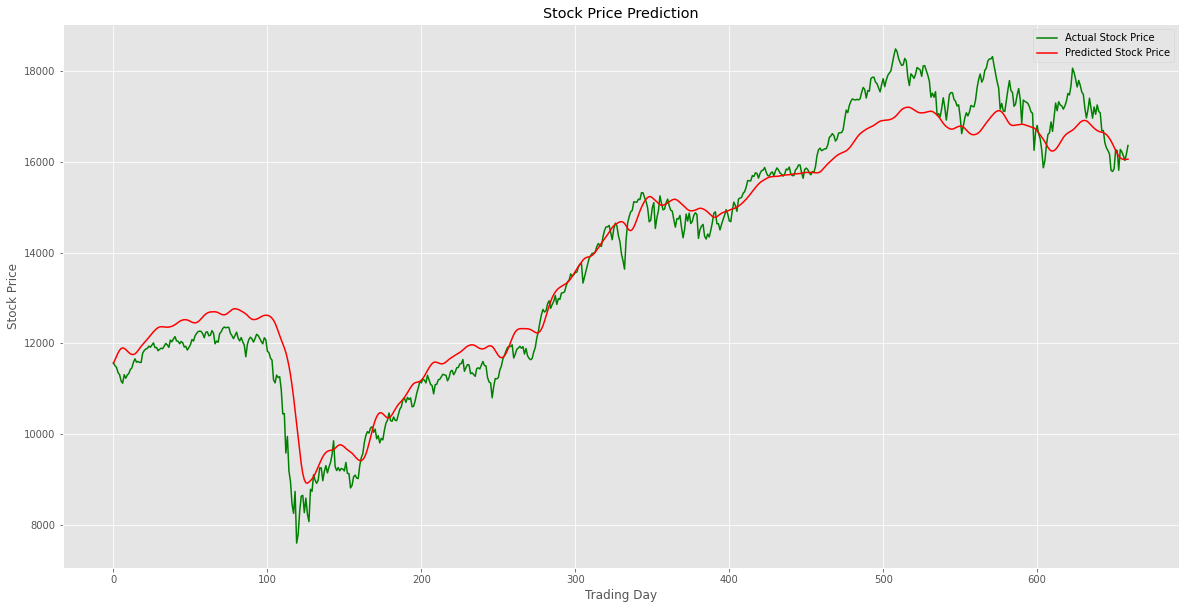

In [26]:
#Visualizing the prediction
plt.figure(figsize=(20,10))
plt.plot(y_test_rescale, color = 'green', label = 'Actual Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#### Visualize the training and test data set stock prices

In [27]:
Price_actual = trainPrices.tolist() + testPrices[time_steps:].tolist()
Price_Predicted = trainPrices.tolist() + predicted_stock_price.tolist()

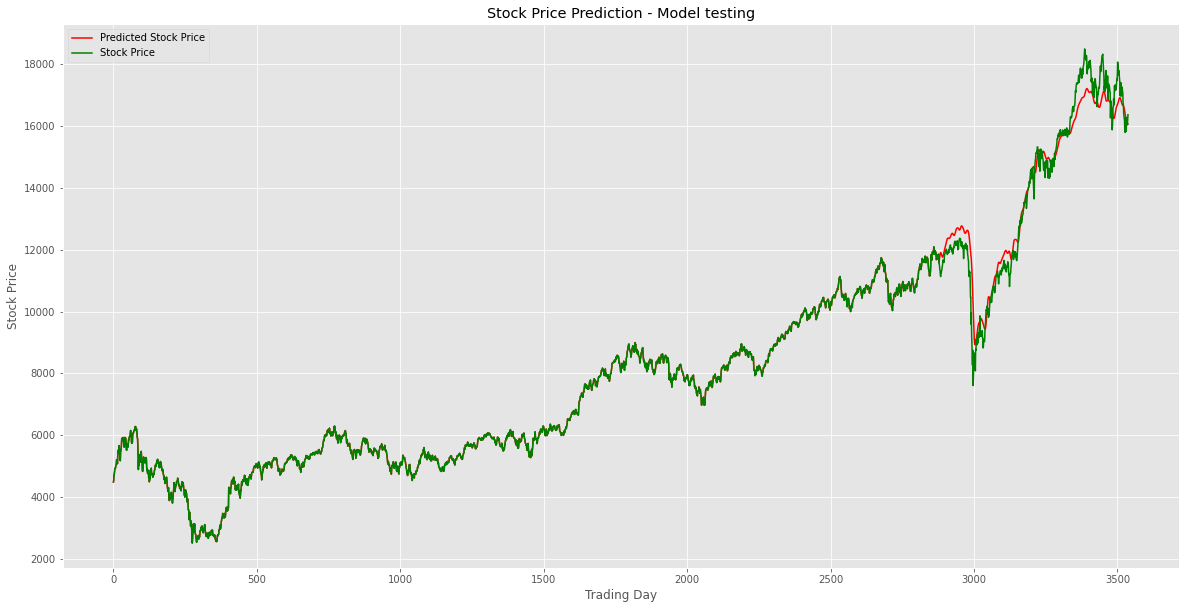

In [28]:
plt.figure(figsize=(20,10))
plt.plot(Price_Predicted, color = 'red', label = 'Predicted Stock Price')
plt.plot(Price_actual, color = 'green', label = 'Stock Price')
plt.title('Stock Price Prediction - Model testing')
plt.xlabel('Trading Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Save the model

In [29]:
import datetime
now = datetime.date.today().strftime("%Y-%m-%d")

modelFileName = 'LSTM_'+ str(time_steps) + 'D_ClosePrice_' + now + '.h5'

In [30]:
# creates a HDF5 file
regressor.save(modelFileName)

## Clean up variables and release the memory

In [31]:
# deletes the existing model
#del regressor

# Set all big variables as null

# Load the model and predict the future values

#### Load the model 

In [32]:
from keras.models import load_model
modelFileName = 'LSTM_60D_ClosePrice_2022-05-29.h5'

# returns a compiled model identical to the previous one
savedModel = load_model(modelFileName)

In [33]:
# Store all prices to another list, to be used to visualize future prediction
allPastPrices = np.array([PriceDataSet.loc[:,'Close']]).transpose()

## Predict future prices

In [34]:
# Get the last few prices to create a starting list for predicting the next day's price

future_pred = sc.transform(allPastPrices[-time_steps:])

In [35]:
# Keep shifting the time step and keep adding the predicted value to the list

for i in range(0,pred_days):
  current_seq = np.array([future_pred[i:i+time_steps]]).reshape(-1 ,1)
  current_seq = current_seq.transpose()
  current_seq = np.reshape(current_seq, (1, time_steps, 1))
  next_future_pred = savedModel.predict(current_seq)
  #print(next_future_pred)
  future_pred = np.append(future_pred, next_future_pred[0][0])

#### Visualize predicted values

In [36]:
# Inverse transform the predicted value to scale back
Future_Prediction = sc.inverse_transform(np.array([future_pred[-pred_days:]])).transpose()

# Append it to the past prices
Future_Prediction = np.append(allPastPrices, Future_Prediction)

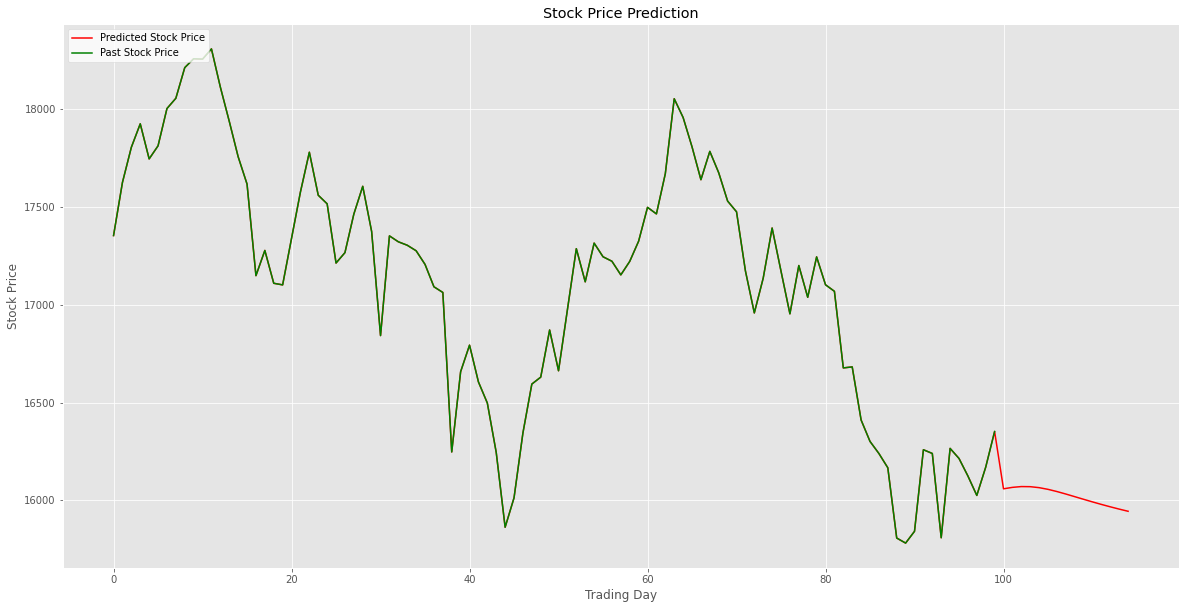

In [37]:
# Visualizing the prediction values

plt.figure(figsize=(20,10))
plt.style.use('ggplot') #Solarize_Light2, dark_background, ggplot
plt.plot(Future_Prediction[-115:], color = 'red', label = 'Predicted Stock Price')
plt.plot(allPastPrices[-100:], color = 'green', label = 'Past Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Stock Price')
plt.legend(facecolor='white', loc=2)
plt.show()

## Visualize Prediction vs Actuals - after the fact

In [ ]:
#actualPrices = allPastPrices.tolist()

# Create another dataframe to be used for Predictions vs Actuals visualization
PriceDataSet_tail = PriceDataSet[n_Tail_Records*-1:]   #PriceDataSet[n_Tail_Records*-1:]

In [ ]:
actualPrices = allPastPrices.tolist() + np.array([PriceDataSet_tail.loc[:,'Close']]).transpose().tolist()

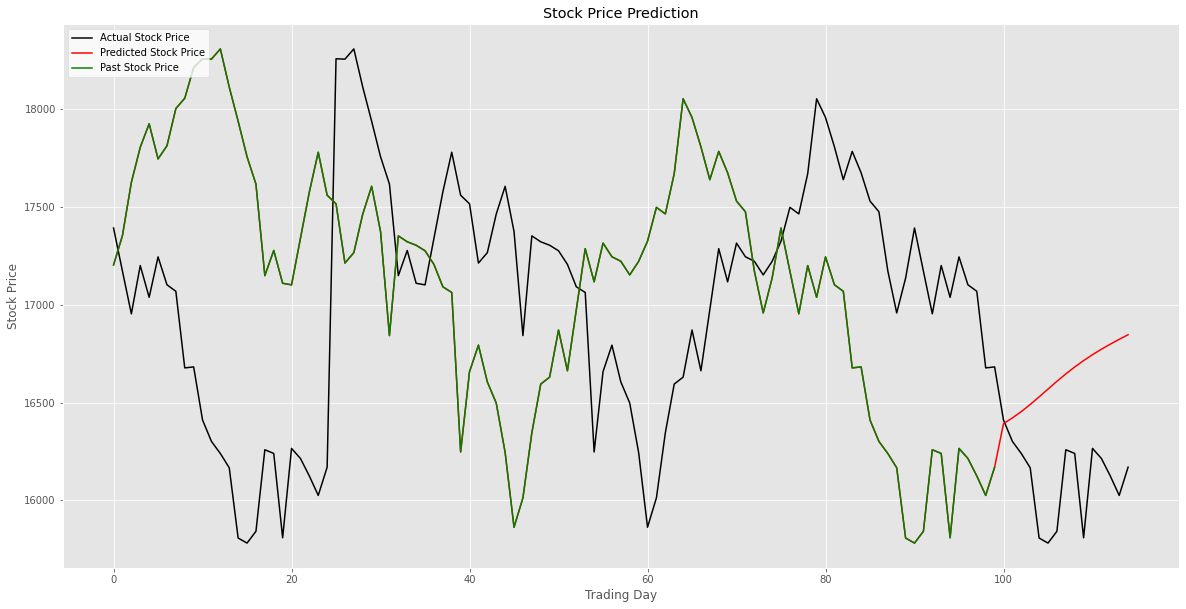

In [ ]:
# Comparing the predection vs actual, after the fact

plt.figure(figsize=(20,10))
plt.style.use('ggplot') #Solarize_Light2, dark_background, ggplot
plt.plot(actualPrices[-115:], color = 'black', label = 'Actual Stock Price')
plt.plot(Future_Prediction[-115:], color = 'red', label = 'Predicted Stock Price')
plt.plot(allPastPrices[-100:], color = 'green', label = 'Past Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Stock Price')
plt.legend(facecolor='white', loc=2)
plt.show()